### Model Correlations
This code computes and plots the correlation of three satellite brightness models for Starlink v1.5 satellites. The first is our model with lab measured BRDF data. The second is a diffuse sphere model. The third is our model with BRDFs inferred from on-orbit brightness measurements.

In [1]:
# Imports
import pandas as pd
import lumos.calculator
import lumos.conversions
import numpy as np
import astropy.time
import astropy.coordinates
import scipy.stats
import matplotlib.pyplot as plt
import satellite_models.diffuse_sphere as diffuse_sphere
import satellite_models.starlink_v1p5 as starlink_v1p5
import satellite_models.starlink_v1p5_1 as starlink_v1p5_1


In [2]:
data = pd.read_csv("../data/pomenis_observations.csv", comment = "#")

satellite_heights = 1000 * (data['satellite_height'].to_numpy())
observation_times = data['observation_time'].to_numpy()
satellite_altitudes = data['satellite_altitude'].to_numpy()
satellite_azimuths = data['satellite_azimuth'].to_numpy()
measured_magnitudes = data['ab_magnitude'].to_numpy()

mount_lemmon = astropy.coordinates.EarthLocation(lat = 32.4434, lon = -110.7881)

In [3]:
intensities_diffuse_sphere = np.zeros_like(measured_magnitudes)
intensities_lab_brdfs = np.zeros_like(measured_magnitudes)
intensities_lab_brdfs_1 = np.zeros_like(measured_magnitudes)
intensities_inferred_brdfs = np.zeros_like(measured_magnitudes)
intensities_inferred_brdfs_1 = np.zeros_like(measured_magnitudes)

for i, (sat_alt, sat_az, sat_h, time) in \
    enumerate(zip(satellite_altitudes, satellite_azimuths, satellite_heights, observation_times)):
    
    observation_time = astropy.time.Time(time, format = 'isot')
    sun_alt, sun_az = lumos.calculator.get_sun_alt_az(observation_time, mount_lemmon)

    intensities_diffuse_sphere[i] = \
        diffuse_sphere.get_intensity(0.65, sat_h, sat_alt, sat_az, sun_alt, sun_az)
    
    intensities_lab_brdfs[i] = \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v1p5.SURFACES_LAB_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = False)
    
    intensities_lab_brdfs_1[i] = \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v1p5_1.SURFACES_LAB_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = False)
    
    intensities_inferred_brdfs[i] = \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v1p5.SURFACES_INFER_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = False)
    
    intensities_inferred_brdfs_1[i] = \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v1p5_1.SURFACES_INFER_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = False)

magnitudes_diffuse_sphere = lumos.conversions.intensity_to_ab_mag(intensities_diffuse_sphere)
magnitudes_lab_brdfs = lumos.conversions.intensity_to_ab_mag(intensities_lab_brdfs)
magnitudes_lab_brdfs_1 = lumos.conversions.intensity_to_ab_mag(intensities_lab_brdfs_1)
magnitudes_inferred_brdfs = lumos.conversions.intensity_to_ab_mag(intensities_inferred_brdfs)
magnitudes_inferred_brdfs_1 = lumos.conversions.intensity_to_ab_mag(intensities_inferred_brdfs_1)

In [4]:
chi_square_statistic = lambda modeled, measured : np.sum( (modeled - measured)**2 / measured ) / len(measured)

Old Model (Lab BRDFs), R = 0.69137
Old Model (Lab BRDFs), X^2 = 0.21581
New Model (Lab BRDFs), R = 0.69431
New Model (Lab BRDFs), X^2 = 0.21357
Old Model (Best-Fit BRDFs), R = 0.68286
Old Model (Best-Fit BRDFs), X^2 = 0.13616
New Model (Best-Fit BRDFs), R = 0.68544
New Model (Best-Fit BRDFs), X^2 = 0.13726
Diffuse Sphere, R = 0.47
Diffuse Sphere, X^2 = 0.27


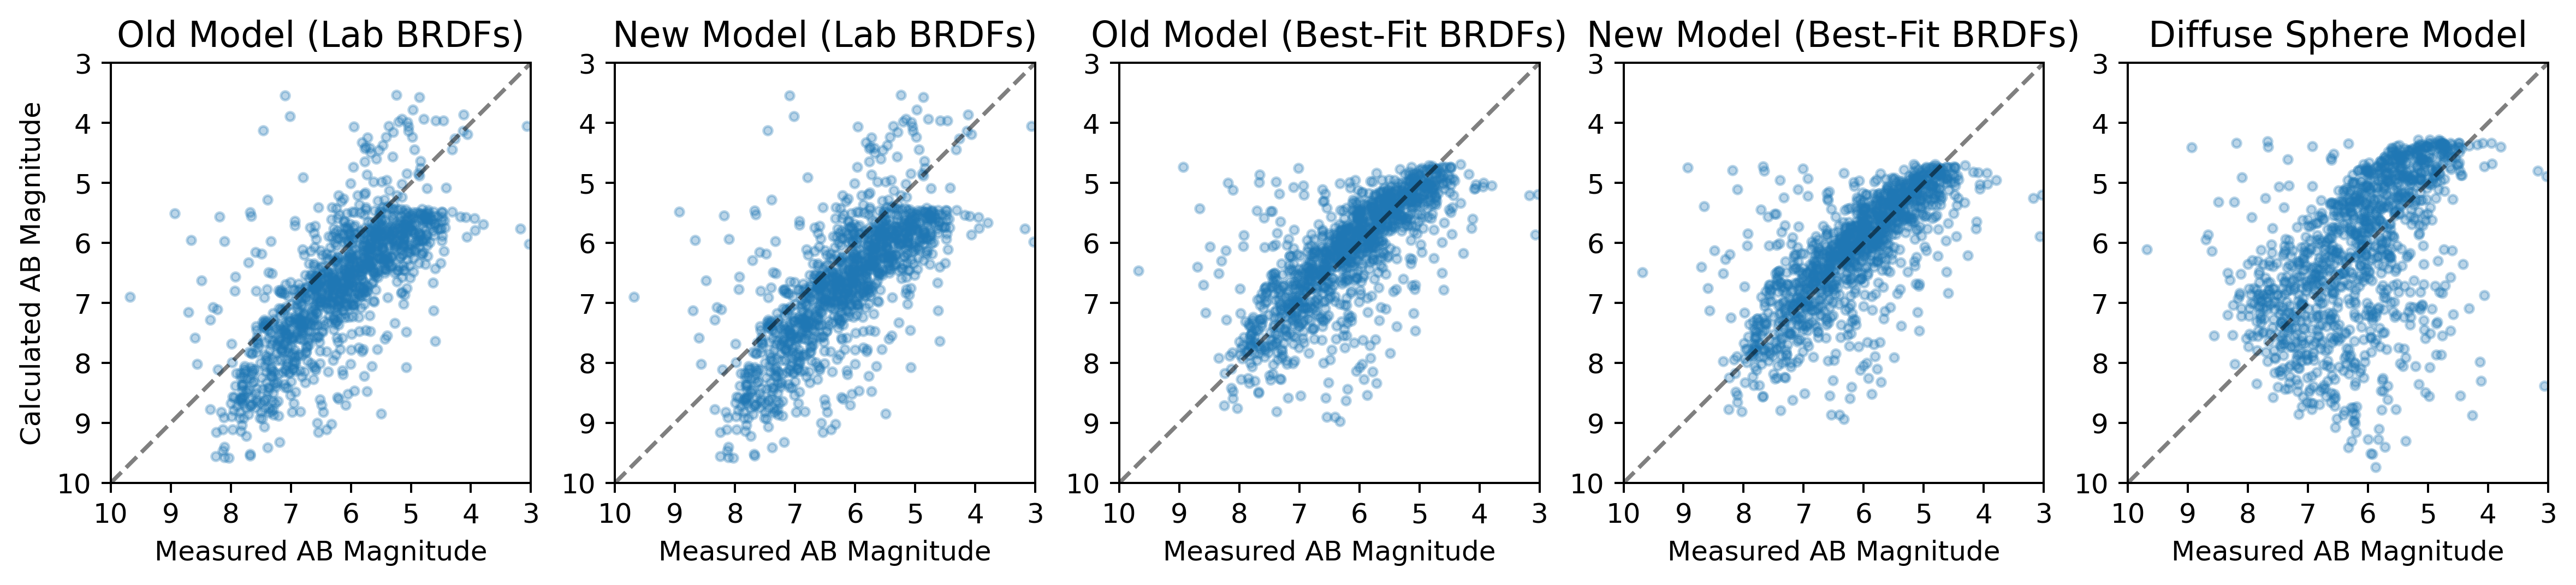

In [5]:
fig, axs = plt.subplots(1, 5, figsize = (16, 5), dpi = 360, sharex = True)
ax1, ax2, ax3, ax4, ax5= axs

for ax in axs:
    ax.set_xlim((3, 10))
    ax.set_ylim((3, 10))
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_aspect("equal")
    ax.set_xlabel("Measured AB Magnitude", fontsize = 10)
    ax.set_ylabel("Calculated AB Magnitude", fontsize = 10)
    ax.plot([10, 2], [10, 2], '--k', alpha = 0.5)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xticks([10, 9, 8, 7, 6, 5, 4, 3])
    ax.set_yticks([10, 9, 8, 7, 6, 5, 4, 3])

ax2.set_ylabel("")
ax3.set_ylabel("")
ax4.set_ylabel("")
ax5.set_ylabel("")

ax1.scatter(measured_magnitudes,
            magnitudes_lab_brdfs,
            color = '#1f77b4',
            alpha = 0.3,
            s = 10)

corr, _ = scipy.stats.pearsonr(magnitudes_lab_brdfs, measured_magnitudes)
chi_sq = chi_square_statistic(magnitudes_lab_brdfs, measured_magnitudes)
print(f"Old Model (Lab BRDFs), R = {corr:0.5f}")
print(f"Old Model (Lab BRDFs), X^2 = {chi_sq:0.5f}")

ax1.set_title("Old Model (Lab BRDFs)", fontsize = 13)


ax2.scatter(measured_magnitudes,
            magnitudes_lab_brdfs_1,
            color = '#1f77b4',
            alpha = 0.3,
            s = 10)

corr, _ = scipy.stats.pearsonr(magnitudes_lab_brdfs_1, measured_magnitudes)
chi_sq = chi_square_statistic(magnitudes_lab_brdfs_1, measured_magnitudes)
print(f"New Model (Lab BRDFs), R = {corr:0.5f}")
print(f"New Model (Lab BRDFs), X^2 = {chi_sq:0.5f}")

ax2.set_title("New Model (Lab BRDFs)", fontsize = 13)

ax3.scatter(measured_magnitudes,
            magnitudes_inferred_brdfs,
            color = '#1f77b4',
            alpha = 0.3,
            s = 10)

corr, _ = scipy.stats.pearsonr(magnitudes_inferred_brdfs, measured_magnitudes)
chi_sq = chi_square_statistic(magnitudes_inferred_brdfs, measured_magnitudes)
print(f"Old Model (Best-Fit BRDFs), R = {corr:0.5f}")
print(f"Old Model (Best-Fit BRDFs), X^2 = {chi_sq:0.5f}")

ax3.set_title("Old Model (Best-Fit BRDFs)", fontsize = 13)

ax4.scatter(measured_magnitudes,
            magnitudes_inferred_brdfs_1,
            color = '#1f77b4',
            alpha = 0.3,
            s = 10)

corr, _ = scipy.stats.pearsonr(magnitudes_inferred_brdfs_1, measured_magnitudes)
chi_sq = chi_square_statistic(magnitudes_inferred_brdfs_1, measured_magnitudes)
print(f"New Model (Best-Fit BRDFs), R = {corr:0.5f}")
print(f"New Model (Best-Fit BRDFs), X^2 = {chi_sq:0.5f}")

ax4.set_title("New Model (Best-Fit BRDFs)", fontsize = 13)


ax5.scatter(measured_magnitudes,
            magnitudes_diffuse_sphere,
            color = '#1f77b4',
            alpha = 0.3,
            s = 10)

corr, _ = scipy.stats.pearsonr(magnitudes_diffuse_sphere, measured_magnitudes)
chi_sq = chi_square_statistic(magnitudes_diffuse_sphere, measured_magnitudes)
print(f"Diffuse Sphere, R = {corr:0.2f}")
print(f"Diffuse Sphere, X^2 = {chi_sq:0.2f}")
ax5.set_title("Diffuse Sphere Model", fontsize = 13)

plt.show()

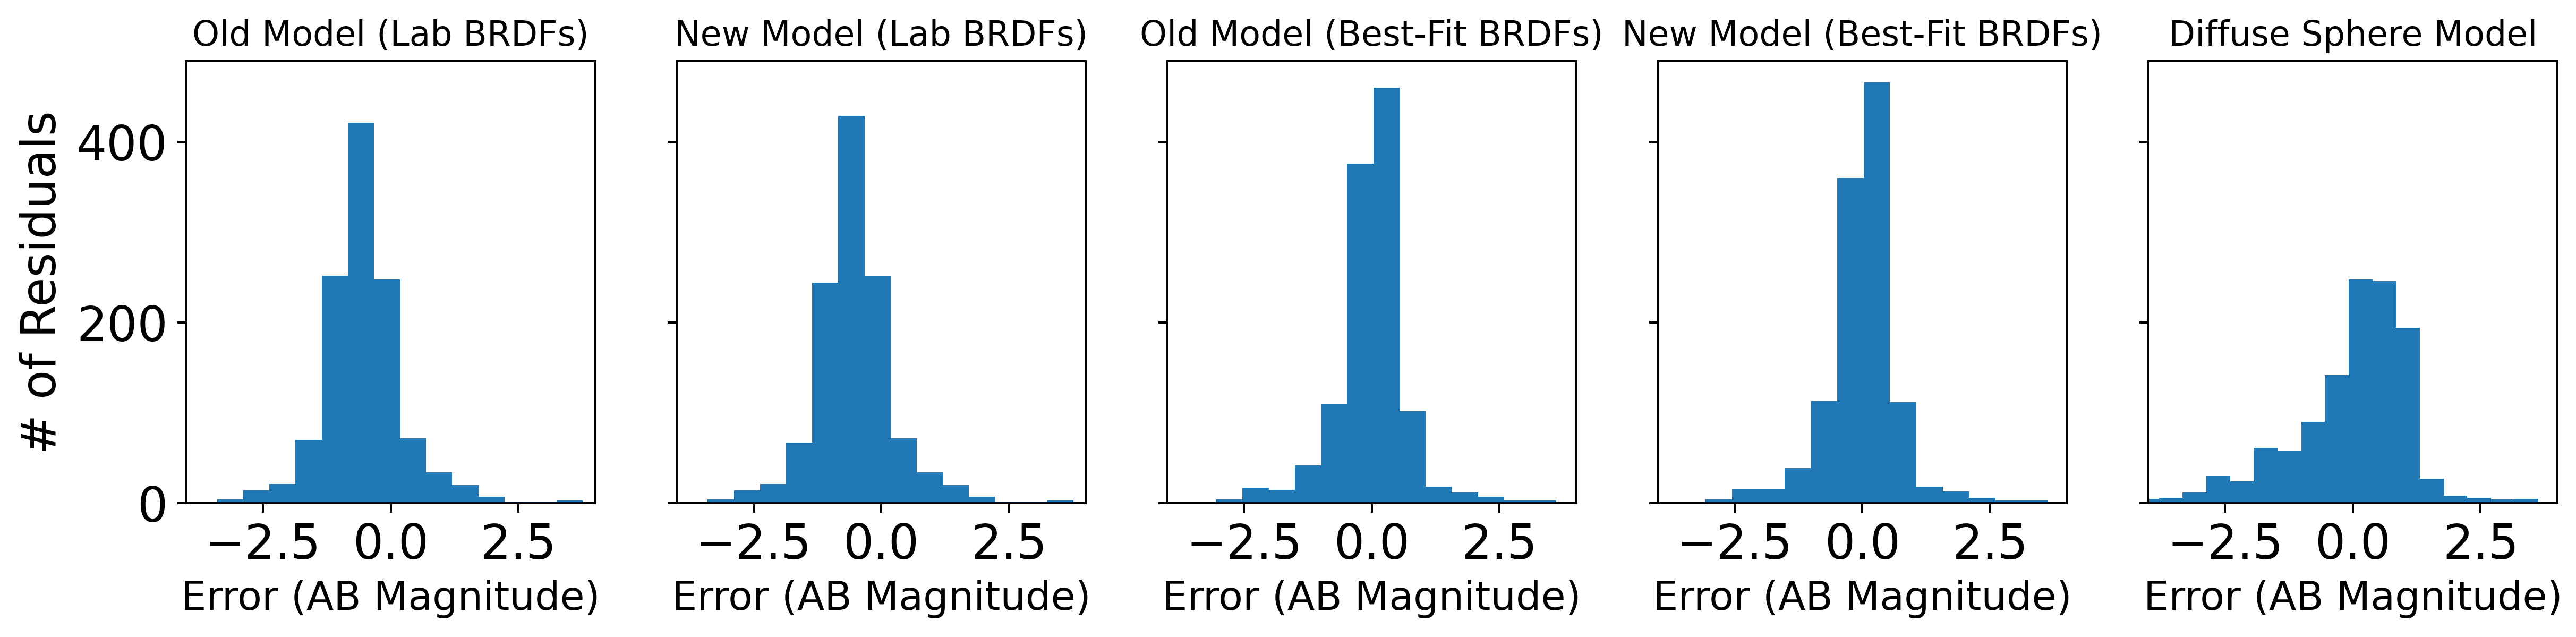

In [7]:
fig, axs = plt.subplots(1, 5, figsize = (16, 3), dpi = 360, sharey = True)
ax1, ax2, ax3, ax4 ,ax5= axs

for ax in axs:
    ax.set_xlim((-4, 4))
    ax.set_xlabel("Error (AB Magnitude)", fontsize = 15)
    ax.set_ylabel("# of Residuals", fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=18)

ax2.set_ylabel("")
ax3.set_ylabel("")
ax4.set_ylabel("")
ax5.set_ylabel("")

ax1.hist(measured_magnitudes - magnitudes_lab_brdfs, bins = 25)
ax1.set_title("Old Model (Lab BRDFs)", fontsize = 13)


ax2.hist(measured_magnitudes - magnitudes_lab_brdfs_1, bins = 25)
ax2.set_title("New Model (Lab BRDFs)", fontsize = 13)

ax3.hist(measured_magnitudes - magnitudes_inferred_brdfs, bins = 25)
ax3.set_title("Old Model (Best-Fit BRDFs)", fontsize = 13)

ax5.hist(measured_magnitudes - magnitudes_diffuse_sphere, bins = 25)
ax5.set_title("Diffuse Sphere Model", fontsize = 13)

ax4.hist(measured_magnitudes - magnitudes_inferred_brdfs_1, bins = 25)
ax4.set_title("New Model (Best-Fit BRDFs)", fontsize = 13)
plt.show()